<h1>Beyond Spell-Checking: Word-Checking</h1>
<h2>An attention based Transformer approach</h2>

<h2> Abdurrahman Shahid</h2>
<h3>L3 MIASHS - SC, University of Lille, France</h3>
<h3>Study and Research Work - Travaux d’Etude et de Recherche (TER) </h3>

<div> <strong>The Transformer implemenation is from the Tensorflow website ('Transformer model for language understanding').</strong></div> 
<div style="color:blue"><strong>The training pipeline and the evaluation of the model are modified and expanded to suit our needs.</strong></div>

##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf

import time
import os
from datetime import datetime
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Change:

filetime (time which occurs in the training file's name)

Tokenizer \
TRAIN_BUFFER_SIZE \
VAL_BUFFER_SIZE \
BATCH_SIZE

# Setup input pipeline (Modified and expanded for our case)

In [2]:
filetime = "2-8-22-50"

In [3]:
train_file_input = "xtrain-{}.txt".format(filetime)
train_file_target = "ytrain-{}.txt".format(filetime)

In [4]:
train_dataset_input = tf.data.TextLineDataset(train_file_input)
train_dataset_target = tf.data.TextLineDataset(train_file_target)

In [5]:
train_dataset = tf.data.Dataset.zip((train_dataset_input, train_dataset_target))

In [6]:
for a,b in train_dataset.take(1):
    print(a.numpy().decode("utf-8"))
    print(b.numpy().decode("utf-8"))

plus mûr, plus expérimenté, il à appris à choisir ses combats.
plus mûr, plus expérimenté, il a appris à choisir ses combats.


In [7]:
next(iter(train_dataset))

(<tf.Tensor: shape=(), dtype=string, numpy=b'plus m\xc3\xbbr, plus exp\xc3\xa9riment\xc3\xa9, il \xc3\xa0 appris \xc3\xa0 choisir ses combats.'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'plus m\xc3\xbbr, plus exp\xc3\xa9riment\xc3\xa9, il a appris \xc3\xa0 choisir ses combats.'>)

load a custom subwords tokenizer

In [8]:
tokenizer = tfds.features.text.SubwordTextEncoder.load_from_file("tokenizer_1024_file_train_tokenizer-133000lines.txt")

#### BATCH SIZE ####

In [9]:
TRAIN_BUFFER_SIZE = 20000
VAL_BUFFER_SIZE = 5000
BATCH_SIZE = 64

Add a start and end token to the input and target. 

In [10]:
def encode(inp, tar):
    inp = [tokenizer.vocab_size] + tokenizer.encode(
        inp.numpy().decode("utf-8")) + [tokenizer.vocab_size+1]
    tar = [tokenizer.vocab_size] + tokenizer.encode(
        tar.numpy().decode("utf-8")) + [tokenizer.vocab_size+1]
    
    return inp, tar

You want to use `Dataset.map` to apply this function to each element of the dataset.  `Dataset.map` runs in graph mode.

* Graph tensors do not have a value. 
* In graph mode you can only use TensorFlow Ops and functions. 

So you can't `.map` this function directly: You need to wrap it in a `tf.py_function`. The `tf.py_function` will pass regular tensors (with a value and a `.numpy()` method to access it), to the wrapped python function.

In [11]:
def tf_encode(inp, tar):
    result_inp, result_tar = tf.py_function(encode, [inp, tar], [tf.int64, tf.int64])
    result_inp.set_shape([None])
    result_tar.set_shape([None])

    return result_inp, result_tar

Note: To keep this example small and relatively fast, drop examples with a length of over 32 tokens.

#### Maximum Length

In [12]:
MAX_LENGTH = 32

In [13]:
def filter_max_length(x, y, max_length=MAX_LENGTH):
    return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)

In [14]:
train_dataset = train_dataset.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)
# cache the dataset to memory to get a speedup while reading from it.
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(TRAIN_BUFFER_SIZE).padded_batch(BATCH_SIZE, padded_shapes=([None],[None]))
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

Prepare validation set

In [15]:
val_file_input = "xval-{}.txt".format(filetime)
val_file_target = "yval-{}.txt".format(filetime)
val_dataset_input = tf.data.TextLineDataset(val_file_input)
val_dataset_target = tf.data.TextLineDataset(val_file_target)
val_dataset = tf.data.Dataset.zip((val_dataset_input, val_dataset_target))


In [16]:
val_dataset = val_dataset.map(tf_encode)
val_dataset = val_dataset.filter(filter_max_length)
# cache the dataset to memory to get a speedup while reading from it.
val_dataset = val_dataset.cache()
val_dataset = val_dataset.shuffle(VAL_BUFFER_SIZE).padded_batch(BATCH_SIZE, padded_shapes=([None],[None]))
val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)

##### Positional encoding

Since this model doesn't contain any recurrence or convolution, positional encoding is added to give the model some information about the relative position of the words in the sentence. 

The positional encoding vector is added to the embedding vector. Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. But the embeddings do not encode the relative position of words in a sentence. So after adding the positional encoding, words will be closer to each other based on the *similarity of their meaning and their position in the sentence*, in the d-dimensional space.

See the notebook on [positional encoding](https://github.com/tensorflow/examples/blob/master/community/en/position_encoding.ipynb) to learn more about it. The formula for calculating the positional encoding is as follows:

$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

In [17]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

In [18]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


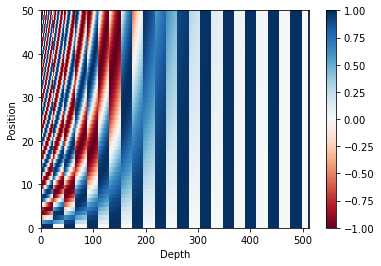

In [19]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## Masking

Mask all the pad tokens in the batch of sequence. It ensures that the model does not treat padding as the input. The mask indicates where pad value `0` is present: it outputs a `1` at those locations, and a `0` otherwise.

In [20]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

The look-ahead mask is used to mask the future tokens in a sequence. In other words, the mask indicates which entries should not be used.

This means that to predict the third word, only the first and second word will be used. Similarly to predict the fourth word, only the first, second and the third word will be used and so on.

In [21]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

## Scaled dot product attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/scaled_attention.png" width="500" alt="scaled_dot_product_attention">

The attention function used by the transformer takes three inputs: Q (query), K (key), V (value). The equation used to calculate the attention weights is:

$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

The dot-product attention is scaled by a factor of square root of the depth. This is done because for large values of depth, the dot product grows large in magnitude pushing the softmax function where it has small gradients resulting in a very hard softmax. 

For example, consider that `Q` and `K` have a mean of 0 and variance of 1. Their matrix multiplication will have a mean of 0 and variance of `dk`. Hence, *square root of `dk`* is used for scaling (and not any other number) because the matmul of `Q` and `K` should have a mean of 0 and variance of 1, and you get a gentler softmax.

The mask is multiplied with -1e9 (close to negative infinity). This is done because the mask is summed with the scaled matrix multiplication of Q and K and is applied immediately before a softmax. The goal is to zero out these cells, and large negative inputs to softmax are near zero in the output.

In [22]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead) 
    but it must be broadcastable for addition.
    
    Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    Returns:
    output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)
    
    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

As the softmax normalization is done on K, its values decide the amount of importance given to Q.

The output represents the multiplication of the attention weights and the V (value) vector. This ensures that the words you want to focus on are kept as-is and the irrelevant words are flushed out.

## Multi-head attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">


Multi-head attention consists of four parts:
*    Linear layers and split into heads.
*    Scaled dot-product attention.
*    Concatenation of heads.
*    Final linear layer.

Each multi-head attention block gets three inputs; Q (query), K (key), V (value). These are put through linear (Dense) layers and split up into multiple heads. 

The `scaled_dot_product_attention` defined above is applied to each head (broadcasted for efficiency). An appropriate mask must be used in the attention step.  The attention output for each head is then concatenated (using `tf.transpose`, and `tf.reshape`) and put through a final `Dense` layer.

Instead of one single attention head, Q, K, and V are split into multiple heads because it allows the model to jointly attend to information at different positions from different representational spaces. After the split each head has a reduced dimensionality, so the total computation cost is the same as a single head attention with full dimensionality.

In [23]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
    
        assert d_model % self.num_heads == 0
    
        self.depth = d_model // self.num_heads
    
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
    
        self.dense = tf.keras.layers.Dense(d_model)
    
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        
        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)
        
        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
        
        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)
        
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth
        
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)
        
        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
        return output, attention_weights

## Point wise feed forward network

Point wise feed forward network consists of two fully-connected layers with a ReLU activation in between.

In [24]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

## Encoder and decoder

<img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png" width="600" alt="transformer">

The transformer model follows the same general pattern as a standard [sequence to sequence with attention model](nmt_with_attention.ipynb). 

* The input sentence is passed through `N` encoder layers that generates an output for each word/token in the sequence.
* The decoder attends on the encoder's output and its own input (self-attention) to predict the next word. 

### Encoder layer

Each encoder layer consists of sublayers:

1.   Multi-head attention (with padding mask) 
2.    Point wise feed forward networks. 

Each of these sublayers has a residual connection around it followed by a layer normalization. Residual connections help in avoiding the vanishing gradient problem in deep networks.

The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis. There are N encoder layers in the transformer.

In [25]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
        return out2

### Decoder layer

Each decoder layer consists of sublayers:

1.   Masked multi-head attention (with look ahead mask and padding mask)
2.   Multi-head attention (with padding mask). V (value) and K (key) receive the *encoder output* as inputs. Q (query) receives the *output from the masked multi-head attention sublayer.*
3.   Point wise feed forward networks

Each of these sublayers has a residual connection around it followed by a layer normalization. The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis.

There are N decoder layers in the transformer.

As Q receives the output from decoder's first attention block, and K receives the encoder output, the attention weights represent the importance given to the decoder's input based on the encoder's output. In other words, the decoder predicts the next word by looking at the encoder output and self-attending to its own output. See the demonstration above in the scaled dot product attention section.

In [26]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()
        
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)
        
        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
        
        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
        return out3, attn_weights_block1, attn_weights_block2

### Encoder

The `Encoder` consists of:
1.   Input Embedding
2.   Positional Encoding
3.   N encoder layers

The input is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the encoder layers. The output of the encoder is the input to the decoder.

In [27]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()
        
        self.d_model = d_model
        self.num_layers = num_layers
        
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)
    
    
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
  
        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        
        seq_len = tf.shape(x)[1]
    
        # adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)
    
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
    
        return x  # (batch_size, input_seq_len, d_model)

### Decoder

 The `Decoder` consists of:
1.   Output Embedding
2.   Positional Encoding
3.   N decoder layers

The target is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the decoder layers. The output of the decoder is the input to the final linear layer.

In [28]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()
        
        self.d_model = d_model
        self.num_layers = num_layers
    
        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
        
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}
        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        
        x = self.dropout(x, training=training)
        
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)
            
            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
            
        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

## Create the Transformer

Transformer consists of the encoder, decoder and a final linear layer. The output of the decoder is the input to the linear layer and its output is returned.

In [29]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
                 target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()
        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)
            
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)
        
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
                
    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        
        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
        
        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        
        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
        
        return final_output, attention_weights

## Set hyperparameters

To keep this example small and relatively fast, the values for *num_layers, d_model, and dff* have been reduced. 

The values used in the base model of transformer were; *num_layers=6*, *d_model = 512*, *dff = 2048*. See the [paper](https://arxiv.org/abs/1706.03762) for all the other versions of the transformer.

Note: By changing the values below, you can get the model that achieved state of the art on many tasks.

In [30]:
num_layers = 2
d_model = 64
dff = 256
num_heads = 4

input_vocab_size = tokenizer.vocab_size + 2
target_vocab_size = tokenizer.vocab_size + 2
dropout_rate = 0.1

## Optimizer

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$


In [31]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [32]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

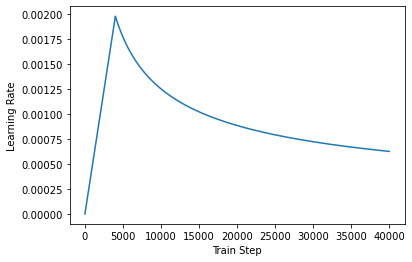

In [33]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## Loss and metrics

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [34]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
# from_logits = True, apply softmax function, returns probability

In [35]:
# pred.shape = (batch_size, seq_len, embed_dimension)

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    
    # mask.shape = (batch_size, seq_len)
    # loss_.shape = (batch_size, seq_len)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
  
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))
  
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)
    
    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [36]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

## Training and checkpointing

In [37]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [38]:
def create_masks(inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)
    
    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)
      
    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by 
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
    
    return enc_padding_mask, combined_mask, dec_padding_mask

Create the checkpoint path and the checkpoint manager. This will be used to save checkpoints every `n` epochs.

In [39]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=250)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [40]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
    
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, 
                                     True, 
                                     enc_padding_mask, 
                                     combined_mask, 
                                     dec_padding_mask)
        loss = loss_function(tar_real, predictions)
    
    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
      
    train_loss(loss)
    train_accuracy(accuracy_function(tar_real, predictions))

In [41]:
val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.Mean(name='val_accuracy')

def val_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
    
    # change training to FALSE
    predictions, _ = transformer(inp, tar_inp, 
                                 False, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)
    
    
    val_loss(loss)
    val_accuracy(accuracy_function(tar_real, predictions))

French sentence with an error (incorrect homophone) is used as the input language and correct sentence is the target.

# TRAIN ###

In [42]:
def train_model(epochs=10):
    
    start_training = datetime.now()
    
    history_train_losses = []
    history_train_accuracies = []
    history_val_losses = []
    history_val_accuracies = []
    
    for epoch in range(epochs):

        if epoch == 0:
            start = time.time()

        train_loss.reset_states()
        train_accuracy.reset_states()
        val_loss.reset_states()
        val_accuracy.reset_states()


        for (batch, (inp, tar)) in enumerate(val_dataset):
            val_step(inp, tar)

        # inp -> homophone with noise, tar -> correct homophone
        for (batch, (inp, tar)) in enumerate(train_dataset):
            train_step(inp, tar)

            #if batch % 4 == 0:
                #print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
                    #epoch + 1, batch, train_loss.result(), train_accuracy.result()))
        if (epoch + 1) % 1 == 0:
            ckpt_save_path = ckpt_manager.save()
            print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))

        if (epoch + 1) % 1 == 0:
            print ('Epoch {} Training Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                                 train_loss.result(), 
                                                                 train_accuracy.result()))
            print ('Epoch {} Validation Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                                 val_loss.result(), 
                                                                 val_accuracy.result()))
            print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))
            start = time.time()

        history_train_losses.append(train_loss.result())
        history_train_accuracies.append(train_accuracy.result())
        history_val_losses.append(val_loss.result())
        history_val_accuracies.append(val_accuracy.result())
        
        pickle.dump(history_train_losses,open("history_train_losses.pickle", "wb"))
        pickle.dump(history_val_losses,open("history_val_losses.pickle", "wb"))
        pickle.dump(history_train_accuracies,open("history_train_accuracies.pickle", "wb"))
        pickle.dump(history_val_accuracies,open("history_val_accuracies.pickle", "wb"))
    
    end_training = datetime.now()
    delta = end_training - start_training
    delta_minutes = int(round(delta.seconds / 60))
    d = delta_minutes
    d_unit = "minutes"
    if delta_minutes == 0:
        d = delta.seconds
        d_unit = "seconds"
    print("\nTime taken for training (~{} {})".format(d, d_unit))

In [43]:
train_model(epochs=75)

Saving checkpoint for epoch 1 at ./checkpoints/train\ckpt-1
Epoch 1 Training Loss 3.8693 Accuracy 0.4002
Epoch 1 Validation Loss 6.9976 Accuracy 0.0006
Time taken for 1 epoch: 85.14414811134338 secs

Saving checkpoint for epoch 2 at ./checkpoints/train\ckpt-2
Epoch 2 Training Loss 0.1179 Accuracy 0.9709
Epoch 2 Validation Loss 0.0972 Accuracy 0.9781
Time taken for 1 epoch: 61.31328320503235 secs

Saving checkpoint for epoch 3 at ./checkpoints/train\ckpt-3
Epoch 3 Training Loss 0.0799 Accuracy 0.9783
Epoch 3 Validation Loss 0.0536 Accuracy 0.9828
Time taken for 1 epoch: 63.101914405822754 secs

Saving checkpoint for epoch 4 at ./checkpoints/train\ckpt-4
Epoch 4 Training Loss 0.0543 Accuracy 0.9849
Epoch 4 Validation Loss 0.0431 Accuracy 0.9862
Time taken for 1 epoch: 61.751935720443726 secs

Saving checkpoint for epoch 5 at ./checkpoints/train\ckpt-5
Epoch 5 Training Loss 0.0410 Accuracy 0.9886
Epoch 5 Validation Loss 0.0346 Accuracy 0.9886
Time taken for 1 epoch: 62.181031465530396 sec

Saving checkpoint for epoch 42 at ./checkpoints/train\ckpt-42
Epoch 42 Training Loss 0.0086 Accuracy 0.9974
Epoch 42 Validation Loss 0.0134 Accuracy 0.9961
Time taken for 1 epoch: 65.28426861763 secs

Saving checkpoint for epoch 43 at ./checkpoints/train\ckpt-43
Epoch 43 Training Loss 0.0088 Accuracy 0.9974
Epoch 43 Validation Loss 0.0138 Accuracy 0.9960
Time taken for 1 epoch: 65.06651282310486 secs

Saving checkpoint for epoch 44 at ./checkpoints/train\ckpt-44
Epoch 44 Training Loss 0.0083 Accuracy 0.9975
Epoch 44 Validation Loss 0.0131 Accuracy 0.9961
Time taken for 1 epoch: 65.09657621383667 secs

Saving checkpoint for epoch 45 at ./checkpoints/train\ckpt-45
Epoch 45 Training Loss 0.0083 Accuracy 0.9975
Epoch 45 Validation Loss 0.0135 Accuracy 0.9960
Time taken for 1 epoch: 65.8761796951294 secs

Saving checkpoint for epoch 46 at ./checkpoints/train\ckpt-46
Epoch 46 Training Loss 0.0081 Accuracy 0.9975
Epoch 46 Validation Loss 0.0138 Accuracy 0.9959
Time taken for 1 epoch: 65.45544

# Evaluate

In [44]:
# metrics from the last training
history_train_losses = pickle.load(open("history_train_losses.pickle","rb"))
history_train_accuracies = pickle.load(open("history_train_accuracies.pickle","rb"))
history_val_losses = pickle.load(open("history_val_losses.pickle","rb"))
history_val_accuracies = pickle.load(open("history_val_accuracies.pickle","rb"))

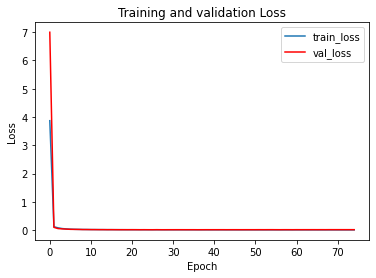

In [45]:
plt.plot(range(len(history_train_losses)), history_train_losses, label="train_loss")
plt.plot(range(len(history_val_losses)), history_val_losses, label="val_loss", color="r")
plt.title("Training and validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

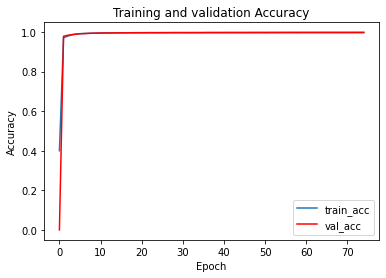

In [46]:
plt.plot(range(len(history_train_accuracies)), history_train_accuracies, label="train_acc")
plt.plot(range(len(history_val_accuracies)), history_val_accuracies, label="val_acc", color="r")
plt.title("Training and validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

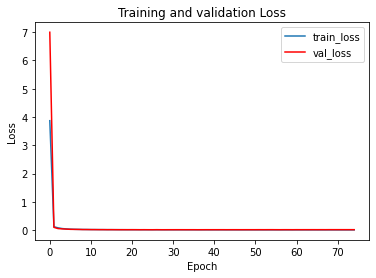

In [47]:
e1, e2 = 0, 75 
plt.plot(range(len(history_train_losses[e1:e2])), history_train_losses[e1:e2], label="train_loss")
plt.plot(range(len(history_val_losses[e1:e2])), history_val_losses[e1:e2], label="val_loss", color="r")
plt.title("Training and validation Loss")
plt.xticks(np.arange(0,75,10))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

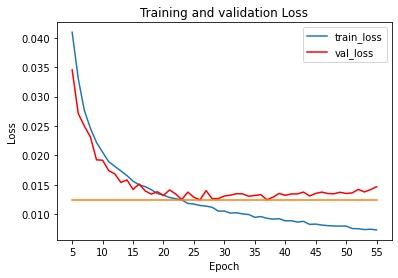

In [48]:
e1, e2 = 4, 55 
plt.plot(range(len(history_train_losses[e1:e2])), history_train_losses[e1:e2], label="train_loss")
plt.plot(range(len(history_val_losses[e1:e2])), history_val_losses[e1:e2], label="val_loss", color="r")
plt.plot(range(len(history_val_losses[e1:e2])), [float(min(history_val_losses[e1:e2]))]*len(history_val_losses[e1:e2]))
plt.title("Training and validation Loss")
plt.xticks(np.arange(0,e2-e1,5), np.arange(e1+1,e2+1,5))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('Loss_.png',dpi=300, bbox_inches='tight')
plt.show()

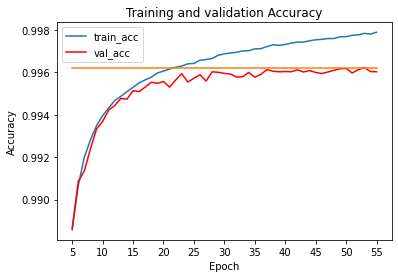

In [49]:
e1, e2 = 4, 55 
plt.plot(range(len(history_train_accuracies[e1:e2])), history_train_accuracies[e1:e2], label="train_acc")
plt.plot(range(len(history_val_accuracies[e1:e2])), history_val_accuracies[e1:e2], label="val_acc", color="r")
plt.plot(range(len(history_val_accuracies[e1:e2])), [float(max(history_val_accuracies[e1:e2]))]*len(history_val_accuracies[e1:e2]))
plt.title("Training and validation Accuracy")
plt.xticks(np.arange(0,e2-e1,5), np.arange(e1+1,e2+1,5))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('Accuracy_.png',dpi=300, bbox_inches='tight')
plt.show()

In [43]:
def evaluate(inp_sentence):
    start_token = [tokenizer.vocab_size]
    end_token = [tokenizer.vocab_size + 1]
    
    # inp sentence is french, hence adding the start and end token
    inp_sentence = start_token + tokenizer.encode(inp_sentence) + end_token
    encoder_input = tf.expand_dims(inp_sentence, 0)
    
    # as the target is english, the first word to the transformer should be the
    # english start token.
    
    decoder_input = [tokenizer.vocab_size]
    output = tf.expand_dims(decoder_input, 0)
    
    for i in range(MAX_LENGTH):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)
  
        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer(encoder_input, 
                                                     output,
                                                     False,
                                                     enc_padding_mask,
                                                     combined_mask,
                                                     dec_padding_mask)
    
        # select the last word from the seq_len dimension
        predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)
        
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        
        # return the result if the predicted_id is equal to the end token
        if predicted_id == tokenizer.vocab_size+1:
            return tf.squeeze(output, axis=0), attention_weights
            
        # concatentate the predicted_id to the output which is given to the decoder
        # as its input.
        output = tf.concat([output, predicted_id], axis=-1)
    
    return tf.squeeze(output, axis=0), attention_weights

In [44]:
def plot_attention_weights(attention, sentence, result, layer):
    fig = plt.figure(figsize=(16, 8))
      
    sentence = tokenizer.encode(sentence)
      
    attention = tf.squeeze(attention[layer], axis=0)
    
    for head in range(attention.shape[0]):
        ax = fig.add_subplot(2, 4, head+1)
        
        # plot the attention weights
        ax.matshow(attention[head][:-1, :], cmap='viridis')
        
        fontdict = {'fontsize': 10}
        
        ax.set_xticks(range(len(sentence)+2))
        ax.set_yticks(range(len(result)-1))
        
        ax.set_ylim(len(result)-1.5, -0.5)
            
        ax.set_xticklabels(
            ['<start>']+[tokenizer.decode([i]) for i in sentence]+['<end>'], 
            fontdict=fontdict, rotation=90)
            
        ax.set_yticklabels([tokenizer.decode([i]) for i in result if i < tokenizer.vocab_size], fontdict=fontdict)
    
        ax.set_xlabel('Head {}'.format(head+1))
        
    plt.tight_layout()
    plt.show()

In [45]:
def verify(sentence, plot=''):
    result, attention_weights = evaluate(sentence)
    
    predicted_sentence = tokenizer.decode([i for i in result if i < tokenizer.vocab_size])  
    
    print('Model input: {}'.format(sentence))
    print('Model output: {}'.format(predicted_sentence))
    
    if plot:
        plot_attention_weights(attention_weights, sentence, result, plot)

### Exemple of model use ###

Correct sentence: mais il y a la mer.
Model input: mais il y à la mer.
Model output: mais il y a la mer.


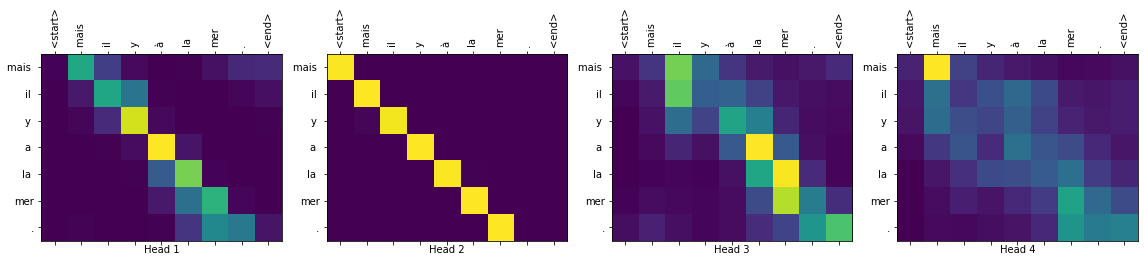

In [53]:
print ("Correct sentence: mais il y a la mer.")
verify("mais il y à la mer.", plot='decoder_layer1_block2')

Correcte sentence: j'ai un compte à régler, affirme rossi.
Model input: j'ai un compte a régler, affirme rossi.
Model output: j'ai un compte à régler, affirme rossi.


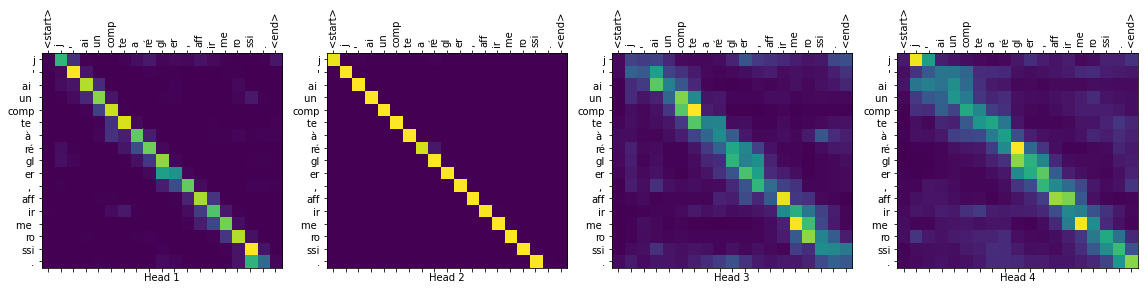

In [54]:
print ("Correcte sentence: j'ai un compte à régler, affirme rossi.")
verify("j'ai un compte a régler, affirme rossi.", plot='decoder_layer1_block2')

Correcte sentence:il va falloir que les gars apprennent à contrôler leurs émotions.
Model input: il va falloir que les gars apprennent à contrôler leur émotions.
Model output: il va falloir que les gars apprennent à contrôler leurs émotions.


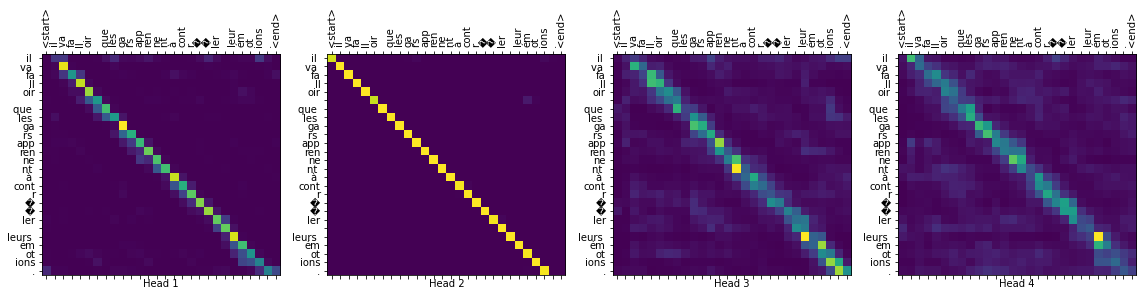

In [55]:
print ("Correcte sentence:il va falloir que les gars apprennent à contrôler leurs émotions.")
verify("il va falloir que les gars apprennent à contrôler leur émotions.", plot='decoder_layer1_block2')

Correcte sentence: distribuer de la nourriture à ceux qui en ont le plus besoin va être un défi.
Model input: distribuer de la nourriture à ce qui en ont le plus besoin va être un défi.
Model output: distribuer de la nourriture à ceux qui en ont le plus besoin va être un défi.


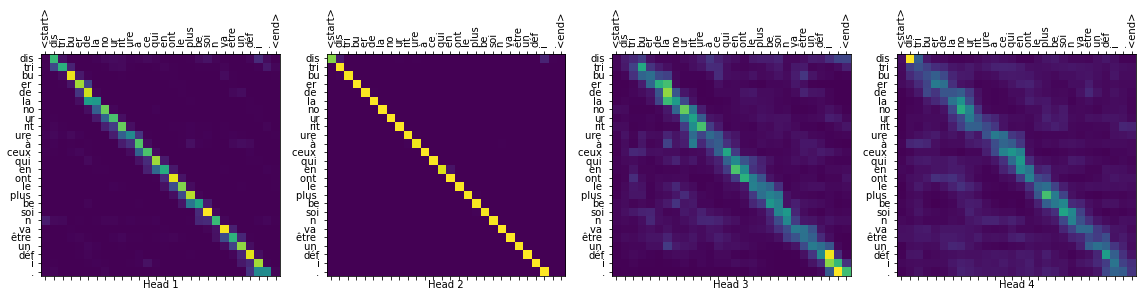

In [56]:
print ("Correcte sentence: distribuer de la nourriture à ceux qui en ont le plus besoin va être un défi.")
verify("distribuer de la nourriture à ce qui en ont le plus besoin va être un défi.", plot='decoder_layer1_block2')

Correcte sentence: distribuer de la nourriture à ceux qui en ont le plus besoin va être un défi.
Model input: distribuer de la nourriture à se qui en ont le plus besoin va être un défi.
Model output: distribuer de la nourriture à ceux qui en ont le plus besoin va être un défi.


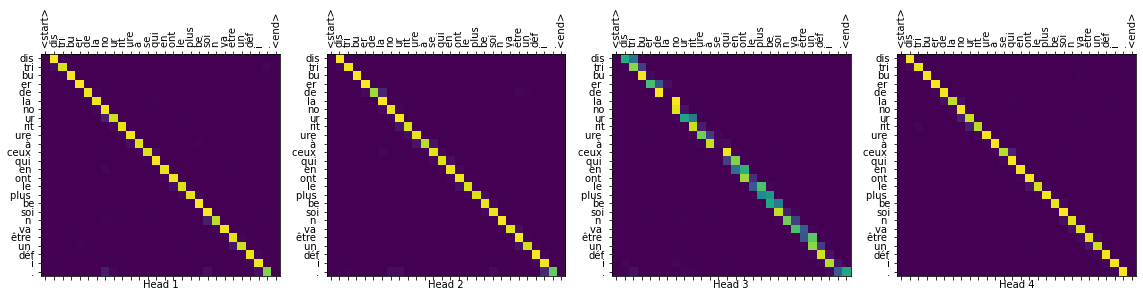

In [57]:
print ("Correcte sentence: distribuer de la nourriture à ceux qui en ont le plus besoin va être un défi.")
verify("distribuer de la nourriture à se qui en ont le plus besoin va être un défi.", plot='decoder_layer2_block2')

You can pass different layers and attention blocks of the decoder to the `plot` parameter.

Correcte sentence: la situation est sous contrôle en ce début de précipitations
Model input: la situation est sous contrôle en se début de précipitations
Model output: la situation est sous contrôle en ce début de précipitations


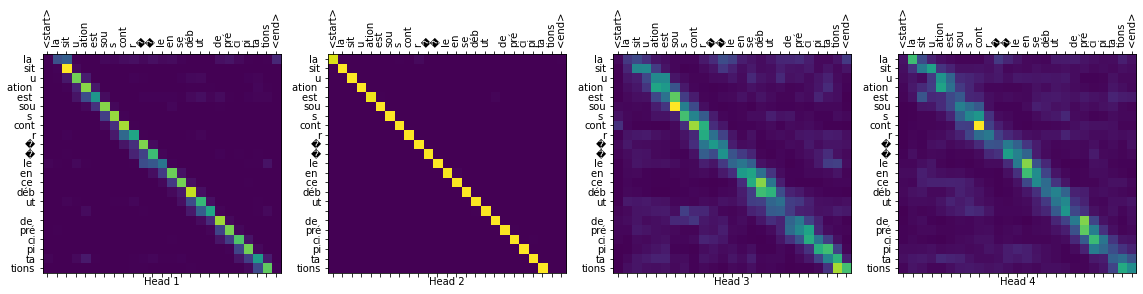

In [58]:
print ("Correcte sentence: la situation est sous contrôle en ce début de précipitations")
verify("la situation est sous contrôle en se début de précipitations", plot='decoder_layer1_block2')

Correcte sentence: il se demande où est ce que cette chose se cache
Model input: il ceux demande ou est se que cet chose ce cache
Model output: il se demande où est ce que cette chose se cache


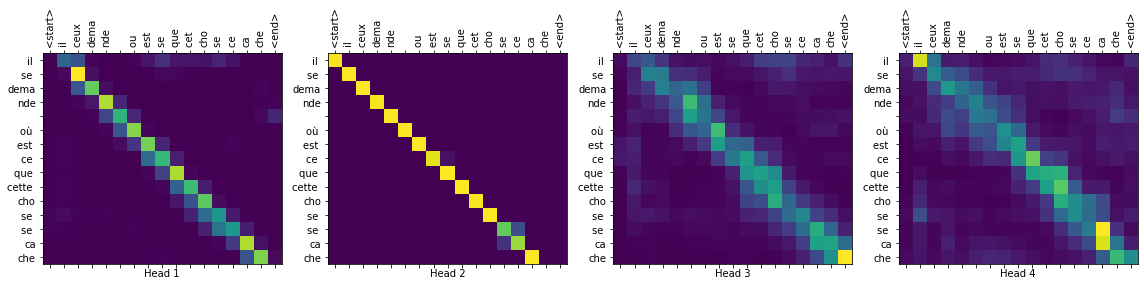

In [59]:
print ("Correcte sentence: il se demande où est ce que cette chose se cache")
verify("il ceux demande ou est se que cet chose ce cache", plot='decoder_layer1_block2')

Correcte sentence: il se demande où est ce que cette chose se cache
Model input: il ceux demande ou est se que cet chose ce cache
Model output: il se demande où est ce que cette chose se cache


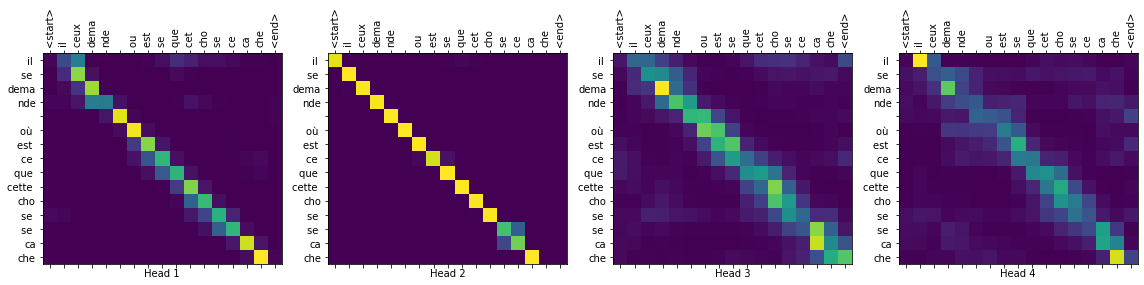

In [45]:
print ("Correcte sentence: il se demande où est ce que cette chose se cache")
verify("il ceux demande ou est se que cet chose ce cache", plot='decoder_layer1_block2')

### The model has 431 490 trainable parameters

In [60]:
def product_list(l):
    prod = 1
    for e in l:
        prod = prod*e
    return prod

In [61]:
total_params = 0
for e in transformer.trainable_weights:
    #print(e.shape)
    shape_list = [dim for dim in e.shape]
    prod_shape = product_list(shape_list)
    #print("e.shape = {}, product = {}".format(e.shape,prod_shape))
    total_params += prod_shape
print("\nTotal parameters: {}".format(total_params))


Total parameters: 431490


In [62]:
total_params = 0
for e in transformer.trainable_variables:
    #print(e.shape)
    shape_list = [dim for dim in e.shape]
    prod_shape = product_list(shape_list)
    #print("e.shape = {}, product = {}".format(e.shape,prod_shape))
    total_params += prod_shape
print("\nTotal parameters: {}".format(total_params))


Total parameters: 431490


# Test the model on the test set and on the questions present in the online form

In [46]:
homophones = [
    ("a","à"),
    ("est","et"),
    ("ces","ses"),
    ("ce","se"),
    ("ou","où"),
    ("la","là"),
    ("tout","tous"),
    ("leur","leurs"),
    ("ceux","ce"),
    ("cette","cet")
]

In [51]:
def get_statistics(homophones, time_index, csv_name="Counts.csv"):
    
    start_func = datetime.now()
    
    homophones_reverse = [(b,a) for (a,b) in homophones]
    homophones_index = []
    for i in range(len(homophones)):
        homophones_index.append(homophones[i])
        homophones_index.append(homophones_reverse[i])
    
    df = pd.DataFrame(index=homophones_index, columns=["TP","FP","TN","FN","Unexpected"])
    
    unexpfile = open("unexpected-outputs-{}.txt".format(time_index), "w", encoding="utf-8")
    
    for (a,b) in homophones_index:
        start = datetime.now()
        print("\n(a,b)=({},{})".format(a,b))
        
        xtesta = open("xtest-{}-{}-{}.txt".format(a,b,time_index), "r", encoding="utf-8")
        ytesta = open("ytest-{}-{}-{}.txt".format(a,b,time_index), "r", encoding="utf-8")
        xtesta_incorrect = open("xtest-{}-{}-{}-incorrect.txt".format(b,a,time_index), "r", encoding="utf-8")
        ytesta_incorrect = open("ytest-{}-{}-{}-incorrect.txt".format(b,a,time_index), "r", encoding="utf-8")

        TN, FP, TP, FN, Wrong = 0, 0, 0, 0, 0

        # TN and FP
        stop = False
        while not stop:
            input_sentence = xtesta.readline()
            input_sentence = input_sentence.strip()
            correct_sentence = ytesta.readline()
            correct_sentence = correct_sentence.strip()

            if not input_sentence:
                stop = True
                break

            output_tokens, _ = evaluate(input_sentence)
            output_sentence = tokenizer.decode([i for i in output_tokens if i < tokenizer.vocab_size]) 

            if output_sentence.strip() == correct_sentence.strip():
                TN += 1
                #print("=== TN ===")
                #print("input: ",input_sentence)
                #print("model output: ", output_sentence.strip())
            else:
                aspace = " " + a + " "
                bspace = " " + b + " "
                input_sentence_fp = input_sentence.replace(aspace,bspace,1)
                if output_sentence.strip() == input_sentence_fp.strip():
                    FP += 1
                    #print("=== FP ===")
                    #print("input: ",input_sentence)
                    #print("model output: ", output_sentence.strip())
                else:
                    Wrong += 1
                    unexpfile.write("(a,b)=({},{})\n".format(a,b))
                    unexpfile.write("Input: {}\n".format(input_sentence.strip()))
                    unexpfile.write("Correct output: {}\n".format(correct_sentence.strip()))
                    unexpfile.write("Unexpected output: {}\n\n\n".format(output_sentence.strip()))
                    #print("=== WRONG ===")
                    #print("input: ",input_sentence)
                    #print("model output: ", output_sentence.strip())

        # TP and FN
        stop = False
        while not stop:
            input_sentence = xtesta_incorrect.readline()
            input_sentence = input_sentence.strip()
            correct_sentence = ytesta_incorrect.readline()
            correct_sentence = correct_sentence.strip()

            if not input_sentence:
                stop = True
                break

            output_tokens, _ = evaluate(input_sentence)
            output_sentence = tokenizer.decode([i for i in output_tokens if i < tokenizer.vocab_size]) 

            if output_sentence.strip() == correct_sentence.strip():
                TP += 1
                #print("=== TP ===")
                #print("input: ",input_sentence)
                #print("model output: ", output_sentence.strip())
            else:
                if output_sentence.strip() == input_sentence.strip():
                    FN += 1
                    #print("=== FN ===")
                    #print("input: ",input_sentence)
                    #print("model output: ", output_sentence.strip())
                else:
                    Wrong += 1
                    unexpfile.write("(a,b)=({},{})\n".format(a,b))
                    unexpfile.write("Input: {}\n".format(input_sentence.strip()))
                    unexpfile.write("Correct output: {}\n".format(correct_sentence.strip()))
                    unexpfile.write("Unexpected output: {}\n\n\n".format(output_sentence.strip()))
                    #print("=== WRONG ===")
                    #print("input: ",input_sentence)
                    #print("model output: ", output_sentence.strip())
        xtesta.close()
        ytesta.close()
        xtesta_incorrect.close()
        ytesta.close()

        end = datetime.now()
        delta = end - start
        delta_minutes = delta.seconds // 60
        d = delta_minutes
        d_unit = "minutes"
        if delta_minutes == 0:
            d = delta.seconds
            d_unit = "seconds"
        print("Time taken for test (~{} {})".format(d, d_unit))
        print("TP={}, FP={}, TN={}, FN={}, Unexpected={}\n".format(TP, FP, TN, FN, Wrong))
        df_index = list(df.index).index((a,b))
        df.iloc[df_index,:] = [TP, FP, TN, FN, Wrong]
    
    unexpfile.close()
    df.to_csv(csv_name, header=True, index=True, encoding="utf-8", sep=",")
    print("\nCSV file '{}' successfully saved.".format(csv_name))
    
    end_func = datetime.now()
    delta_func = end_func - start_func
    delta_minutes = delta_func.seconds // 60
    d = delta_minutes
    d_unit = "minutes"
    if delta_minutes == 0:
        d = delta.seconds
        d_unit = "seconds"
    print("Time taken for the entire test (~{} {})".format(d, d_unit))
    
    return df

In [52]:
get_statistics(homophones,"2-8-22-50", "Counts-2-8-22-50.csv")


(a,b)=(a,à)
Time taken for test (~16 minutes)
TP=407, FP=7, TN=489, FN=87, Unexpected=10


(a,b)=(à,a)
Time taken for test (~16 minutes)
TP=428, FP=2, TN=493, FN=63, Unexpected=14


(a,b)=(est,et)
Time taken for test (~15 minutes)
TP=395, FP=33, TN=464, FN=89, Unexpected=19


(a,b)=(et,est)
Time taken for test (~16 minutes)
TP=303, FP=4, TN=495, FN=183, Unexpected=15


(a,b)=(ces,ses)
Time taken for test (~15 minutes)
TP=368, FP=53, TN=440, FN=127, Unexpected=12


(a,b)=(ses,ces)
Time taken for test (~15 minutes)
TP=306, FP=34, TN=456, FN=187, Unexpected=17


(a,b)=(ce,se)
Time taken for test (~15 minutes)
TP=437, FP=2, TN=488, FN=59, Unexpected=14


(a,b)=(se,ce)
Time taken for test (~15 minutes)
TP=426, FP=3, TN=497, FN=62, Unexpected=12


(a,b)=(ou,où)
Time taken for test (~15 minutes)
TP=455, FP=27, TN=468, FN=36, Unexpected=14


(a,b)=(où,ou)
Time taken for test (~15 minutes)
TP=447, FP=33, TN=464, FN=52, Unexpected=4


(a,b)=(la,là)
Time taken for test (~14 minutes)
TP=456, FP=1

,TP,FP,TN,FN,Unexpected
"(a, à)",407,7,489,87,10
"(à, a)",428,2,493,63,14
"(est, et)",395,33,464,89,19
"(et, est)",303,4,495,183,15
"(ces, ses)",368,53,440,127,12
"(ses, ces)",306,34,456,187,17
"(ce, se)",437,2,488,59,14
"(se, ce)",426,3,497,62,12
"(ou, où)",455,27,468,36,14
"(où, ou)",447,33,464,52,4


In [56]:
dfc = pd.read_csv("Counts-2-8-22-50.csv", header=0, index_col=0,encoding="utf-8")
dfc

,TP,FP,TN,FN,Unexpected
"('a', 'à')",407,7,489,87,10
"('à', 'a')",428,2,493,63,14
"('est', 'et')",395,33,464,89,19
"('et', 'est')",303,4,495,183,15
"('ces', 'ses')",368,53,440,127,12
"('ses', 'ces')",306,34,456,187,17
"('ce', 'se')",437,2,488,59,14
"('se', 'ce')",426,3,497,62,12
"('ou', 'où')",455,27,468,36,14
"('où', 'ou')",447,33,464,52,4


In [64]:
# There is 228 'Unexpected' output for all 20 000 test sentences ( = 1.14 %)
dfc["Unexpected"].sum(), dfc['Unexpected'].sum() / dfc.sum().sum()

(228, 0.0114)

In [1]:
# Recall = TP / (TP + FP)
# Precision = TP / (TP + FN)
# Here we have also the "Unexpected category" see the final report for more information.
# Accuracy = (TP + TN) / (TP + FP+ TN + FN + Unexpected)
# Recall, Precision, Accuracy

In [49]:
def test_on_forms(filename):
    
    start = datetime.now()
    
    sentences = open(filename, "r", encoding="utf-8")
    outname = filename[:-4] + "_transformer_correction.txt"
    
    outputs = open(outname, "w", encoding="utf-8")
    
    stop = False
    while not stop:
        input_sentence = sentences.readline()
        if not input_sentence:
            stop = True
            outputs.write(input_sentence)
            break
        input_sentence = input_sentence.strip()
        input_sentence = input_sentence.lower()
        #correct_sentence = ytesta_incorrect.readline()
        #correct_sentence = correct_sentence.strip()

        output_tokens, _ = evaluate(input_sentence)
        output_sentence = tokenizer.decode([i for i in output_tokens if i < tokenizer.vocab_size])
        
        output_sentence = output_sentence.strip()+"\n"
        outputs.write(output_sentence)
    
    outputs.close()
    
    end = datetime.now()
    delta = end - start
    delta_minutes = delta.seconds // 60
    d = delta_minutes
    d_unit = "minutes"
    if delta_minutes == 0:
        d = delta.seconds
        d_unit = "seconds"
    print("\nResults successfully saved (~ {} {}).\n{}".format(d,d_unit,outname))
    
    sentences.close()

In [50]:
test_on_forms("test_sentence_ggle_forms_questions.txt")


Results successfully saved (~ 38 seconds).
test_sentence_ggle_forms_questions_transformer_correction.txt


In [64]:
def get_test_results(answersfile, correctionfile, csv_name=None):
    
    start = datetime.now()
    
    answers_file = open(answersfile, "r", encoding="utf-8")
    correction_file = open(correctionfile, "r", encoding="utf-8")
    
    scores = []
    answers = []
    corrections = []
    
    stop=False
    while not stop:
        answer = answers_file.readline()
        correct = correction_file.readline()
        correct = correct.lower()
        if (not answer) or (not correct):
            stop = True
            break
        elif answer.strip() == correct.strip():
            scores.append(1)
        else:
            scores.append(0)
        answers.append(answer.strip())
        corrections.append(correct.strip())
    
    dfscores = pd.DataFrame(scores, index=range(len(scores)), columns=["Scores"])
    dfscores["Answers"] = answers
    dfscores["Corrections"] = corrections
    
    answers_file.close()
    correction_file.close()
    
    end = datetime.now()
    delta = end - start
    delta_minutes = delta.seconds // 60
    d = delta_minutes
    d_unit = "minutes"
    if delta_minutes == 0:
        d = delta.seconds
        d_unit = "seconds"
    
    if csv_name:
        dfscores.to_csv(csv_name, header=True, index=True, encoding="utf-8", sep=",")
        print("\nResults successfully saved (~ {} {}).\n{}".format(d,d_unit,csv_name))
    
    return dfscores

In [65]:
g = get_test_results("test_sentence_ggle_forms_questions_transformer_correction.txt",
                "test_sentence_ggle_forms_correct.txt",
                "test_sentence_ggle_forms_transformer_results.csv")


Results successfully saved (~ 0 seconds).
test_sentence_ggle_forms_transformer_results.csv


In [66]:
# The tained Transformer got 37/40
g

,Scores,Answers,Corrections
0,1,la vente de carte journalière au tarif de 8 € ...,la vente de carte journalière au tarif de 8 € ...
1,1,sauront-ils exploiter la technologie de cet en...,sauront-ils exploiter la technologie de cet en...
2,1,"c'est évidemment peu, ou déjà trop.","c'est évidemment peu, ou déjà trop."
3,1,"face à cette situation de surchauffe, une nett...","face à cette situation de surchauffe, une nett..."
4,1,"puisqu'en mode comme en fleurissement, les ten...","puisqu'en mode comme en fleurissement, les ten..."
5,0,le thème de cette dixième édition était « fête...,le thème de cette dixième édition était « fête...
6,1,le journal a appris de nouveaux détails sur ce...,le journal a appris de nouveaux détails sur ce...
7,1,"au début, ce n’était pas évident, donc j’ai fa...","au début, ce n’était pas évident, donc j’ai fa..."
8,1,"si la réponse à ça, c'est oui, je l'entends.","si la réponse à ça, c'est oui, je l'entends."
9,1,"cela fuse dans tous les sens, c’est du grand n...","cela fuse dans tous les sens, c’est du grand n..."


#### see the notebook 'Comparison_of_model_and_human_performance.ipynb', for a comparison between the model and human performance